In [1]:
import utils as utils

In [2]:
ROAD_COUNTS = 4
CHANGE_SIZE = 10
MAX_STATE_VALUE = 100

In [3]:
EPISODES = 50
EPSILON=1.0
EPSILON_MIN=0.01
EPSILON_DECAY=0.9
LR=1e-5
GAMMA=0.95

In [4]:
from environment import TrafficLightEnv

env = TrafficLightEnv(roads_count=ROAD_COUNTS,change_size=CHANGE_SIZE,max_value=MAX_STATE_VALUE)

env.render()

green light timer [20. 44. 25. 72.]
avg waiting times (-) [141. 117. 136.  89.]
vehicles counts (-) [54. 18. 37. 97.]
in counts (+) [52.  8. 66. 94.]


In [5]:
action = env.action_space.sample()
print('raw action:', action)
action = env.cast_action(action)
print('\ncasted action:', action)

raw action: 5

casted action: [1 2 1 1 1]


In [6]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
import os


class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup      = "agent_weights.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = LR
        self.gamma              = GAMMA
        self.exploration_rate   = EPSILON
        self.exploration_min    = EPSILON_MIN
        self.exploration_decay  = EPSILON_DECAY
        self.brain              = self._build_model()


    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Input(self.state_size))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        
        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
        return model


    def save_model(self):
        self.brain.save(self.weight_backup)


    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state, verbose=0)
        return np.argmax(act_values[0])
    

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
                if (reward < 0):
                    target = self.gamma * np.amax(self.brain.predict(next_state,verbose=0)[0]) - reward
                else:
                    target = self.gamma * np.amax(self.brain.predict(next_state,verbose=0)[0]) + reward
            target_f = self.brain.predict(state,verbose=0)
            target_f[0][action] = target
            self.brain.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [7]:
class TrafficLightControl:
    def __init__(self, env, episodes):
        self.sample_batch_size = 32
        self.episodes          = episodes
        self.env               = env
        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)
        self.total_rewards = []
    def train(self):
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])
                done = False
                score = 0
                episode_rewards = []
                while not done:
                    # self.env.render()
                    action = self.agent.act(state)
                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, [1, self.state_size])
                    self.agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    score += reward
                    episode_rewards.append(reward)
                print("Episode {}# Score: {}".format(index_episode, score))
                self.total_rewards.append(episode_rewards)
                self.agent.replay(self.sample_batch_size)
        finally:
            self.agent.save_model()

In [8]:
trafficLightControl = TrafficLightControl(env, episodes=EPISODES)
trafficLightControl.train()

Episode 0# Score: -18.882499999999993
Episode 1# Score: -18.211250000000007
Episode 2# Score: -22.3878125
Episode 3# Score: -21.66062499999999
Episode 4# Score: -21.633437500000007
Episode 5# Score: -28.515937499999996
Episode 6# Score: -17.808124999999997
Episode 7# Score: -23.860000000000003
Episode 8# Score: -21.005000000000003
Episode 9# Score: -24.566874999999996
Episode 10# Score: -17.645625000000003
Episode 11# Score: -24.2546875
Episode 12# Score: -22.025312499999995
Episode 13# Score: -19.463750000000005
Episode 14# Score: -24.4665625
Episode 15# Score: -23.875937499999996
Episode 16# Score: -26.154999999999998
Episode 17# Score: -24.804375000000004
Episode 18# Score: -19.155
Episode 19# Score: -18.335
Episode 20# Score: -17.355625000000007
Episode 21# Score: -24.39
Episode 22# Score: -22.327187500000008
Episode 23# Score: -19.762812499999995
Episode 24# Score: -17.614375000000006
Episode 25# Score: -15.775624999999996
Episode 26# Score: -17.326249999999998
Episode 27# Score: 

In [9]:
trafficLightControl.agent.exploration_rate

0.009697737297875247

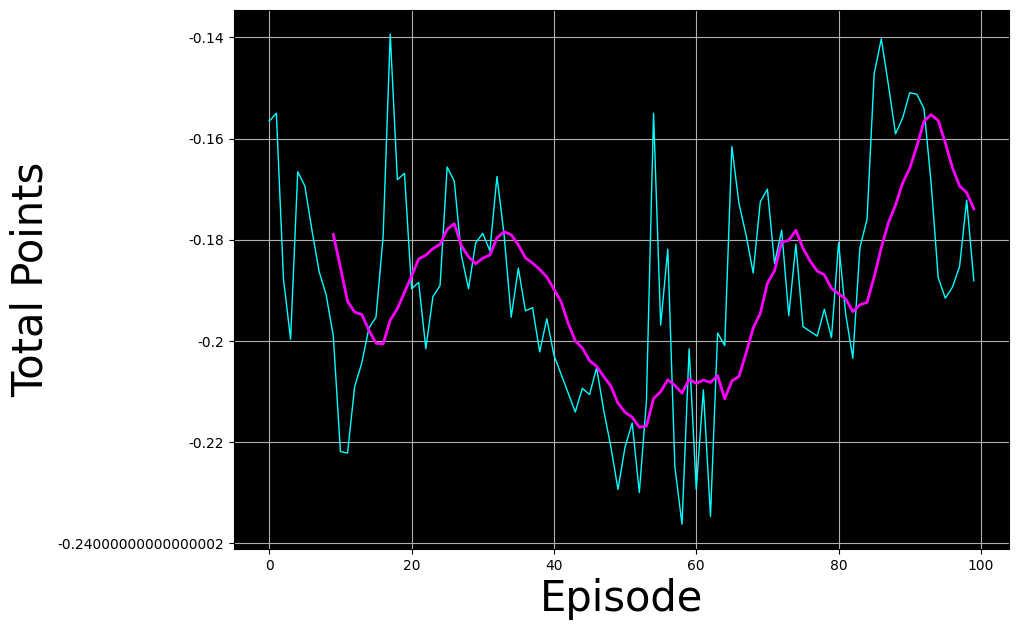

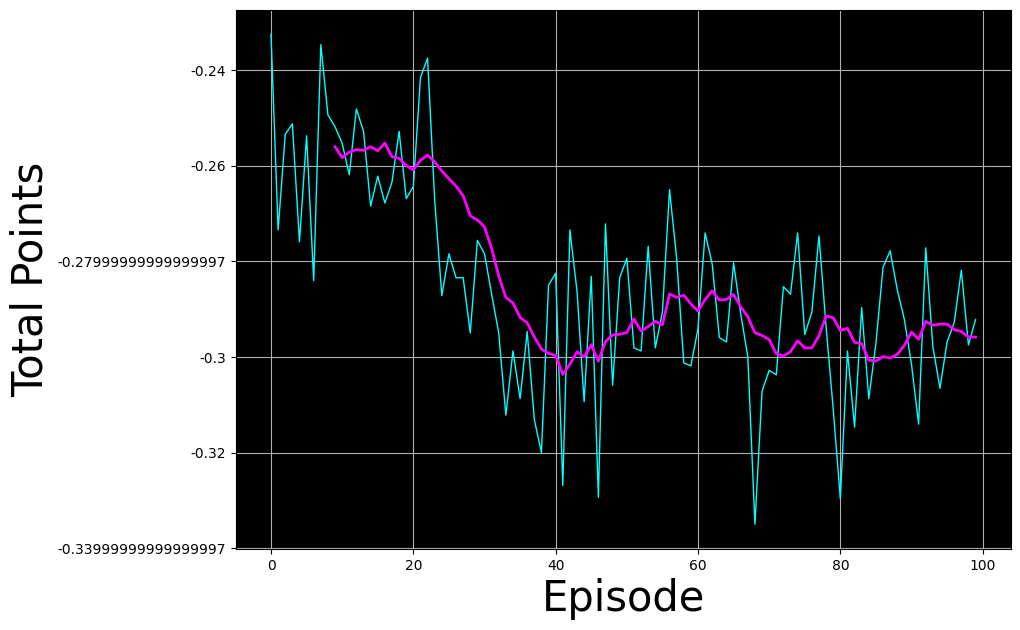

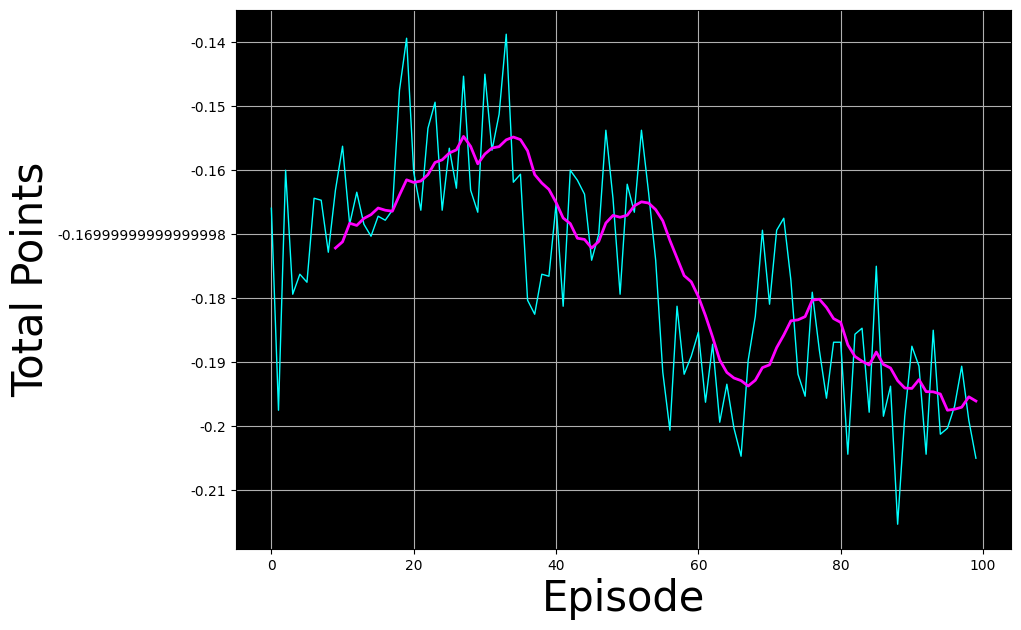

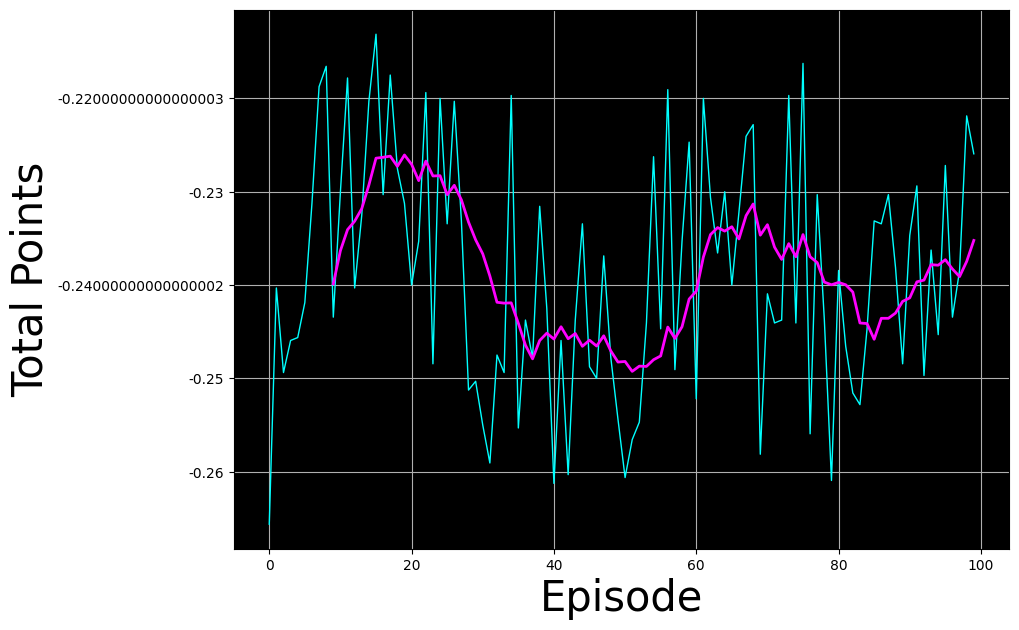

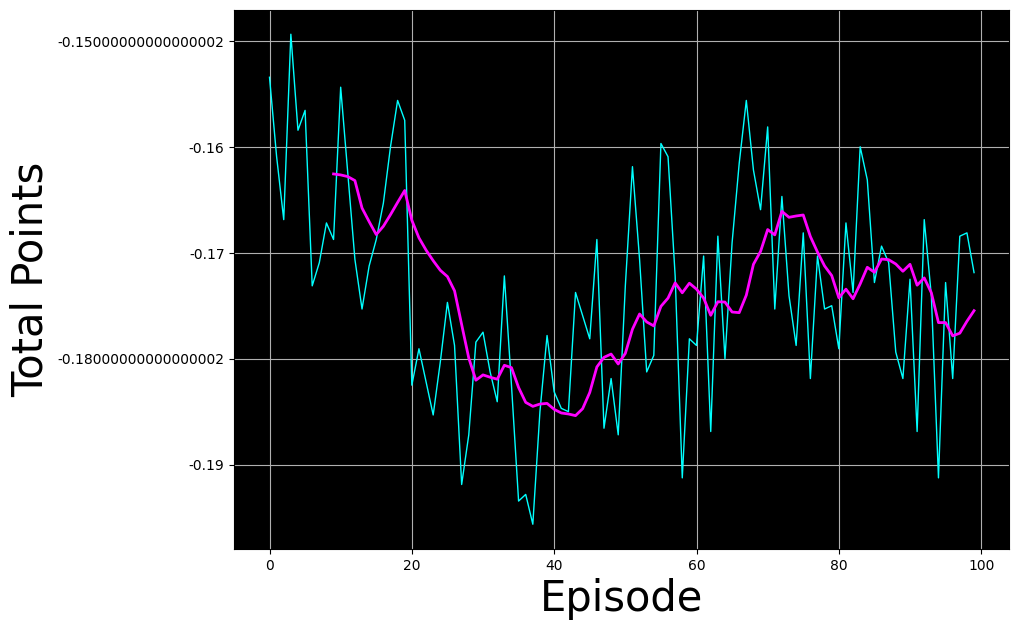

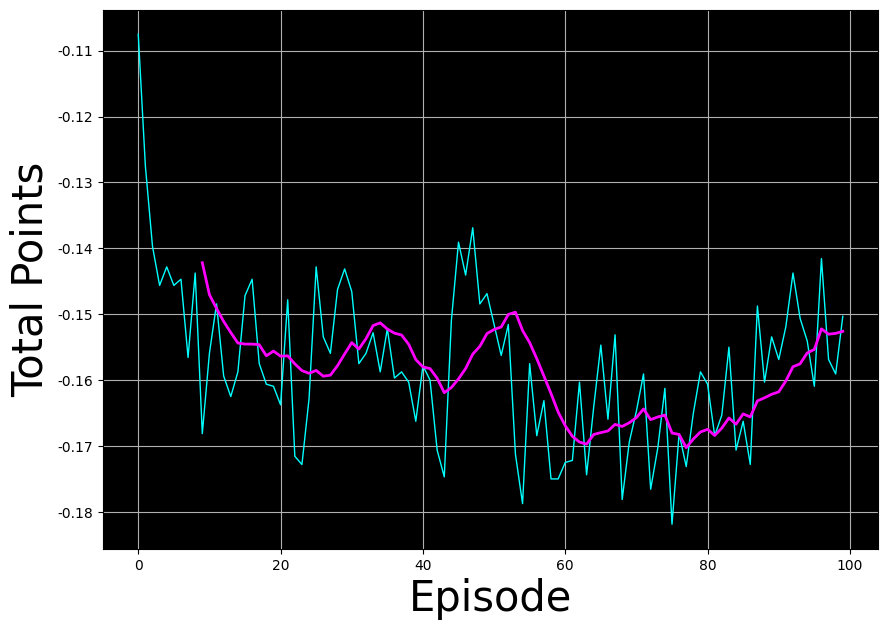

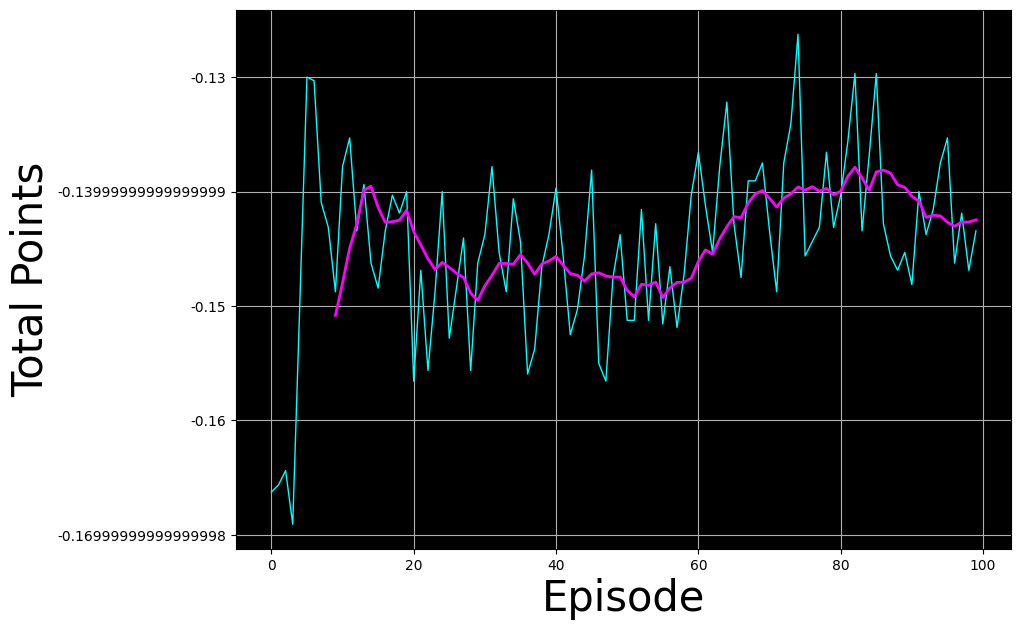

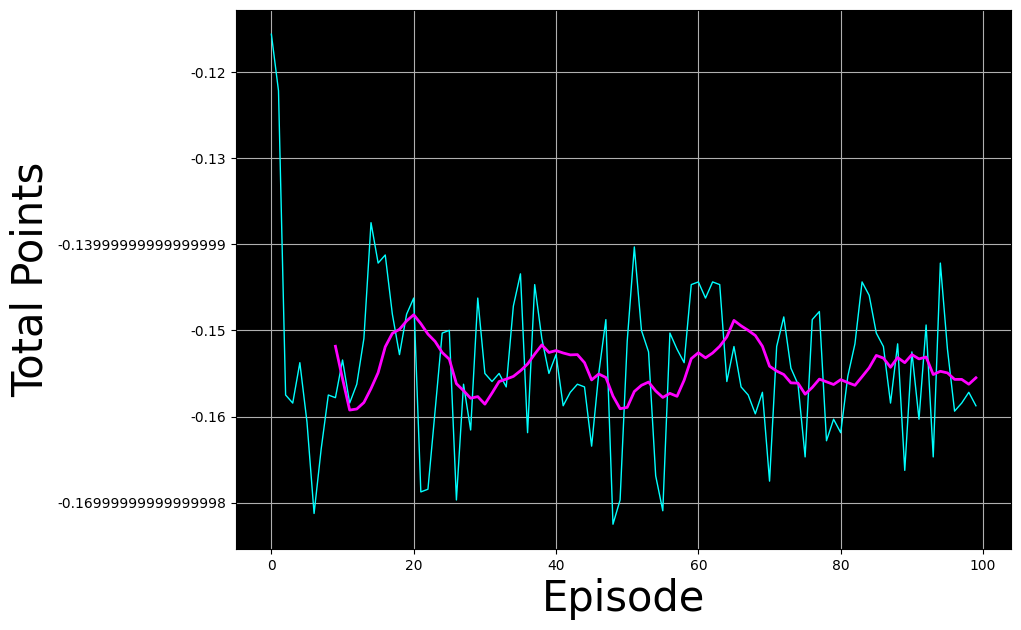

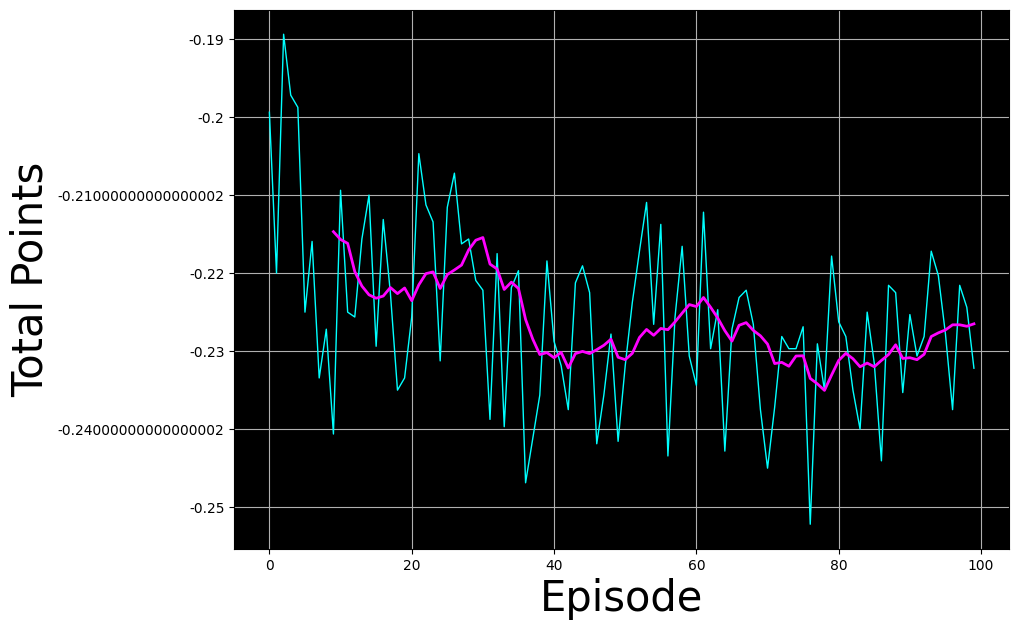

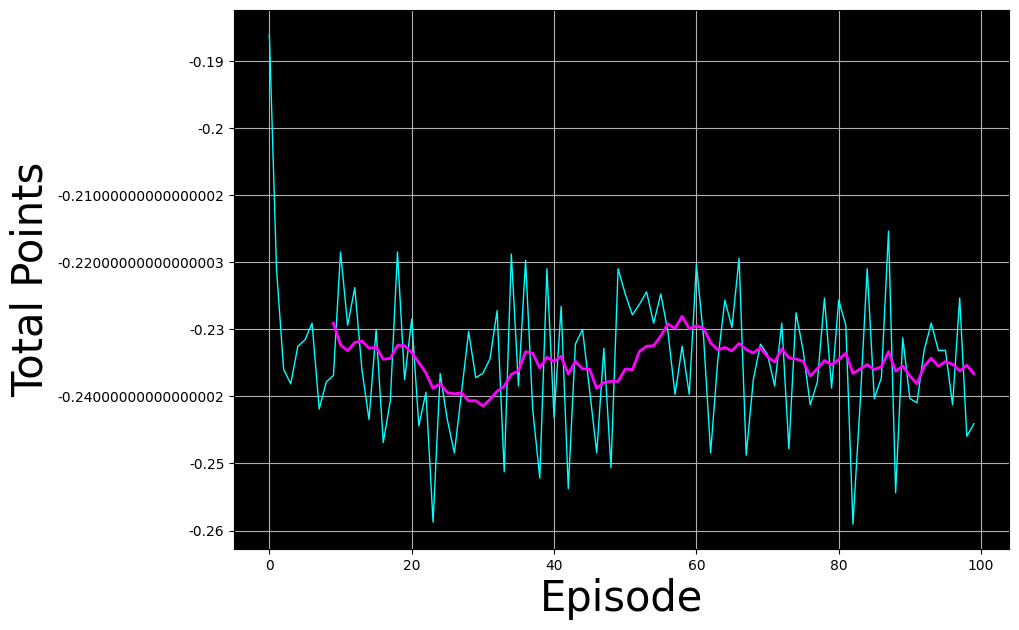

In [10]:
for episode in range(0, EPISODES, EPISODES//10):
    utils.plot_history(trafficLightControl.total_rewards[episode])

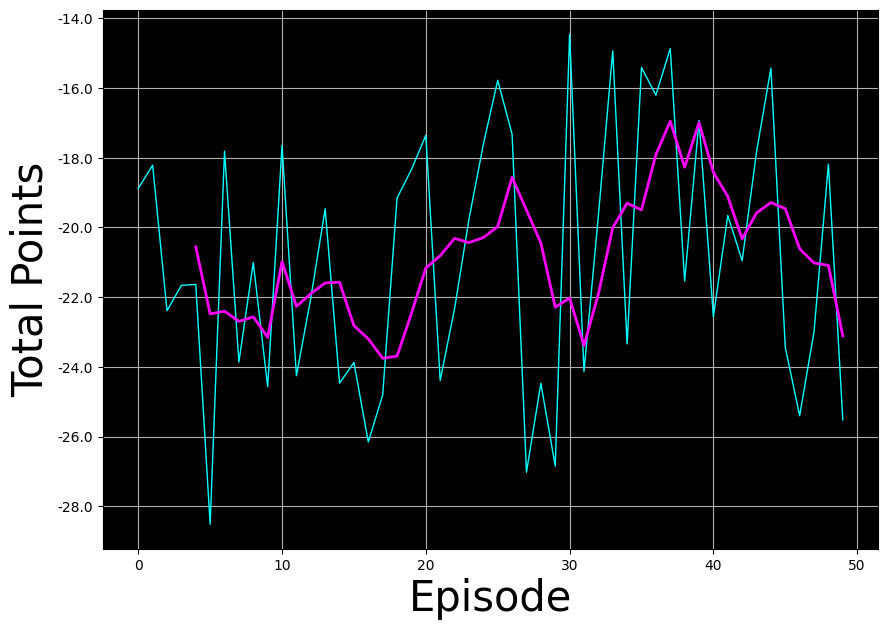

In [11]:
utils.plot_history(np.sum(trafficLightControl.total_rewards, axis=1))

In [12]:
state = env.reset()
state = np.reshape(state, [1, trafficLightControl.state_size])

done = False
test_reward = []
while not done:
    env.render()
    action = trafficLightControl.agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, trafficLightControl.state_size])
    state = next_state
    print('action taken:', env.cast_action(action))
    print('reward:', reward)
    test_reward.append(reward)
    print('')
env.render()

green light timer [73. 98. 84. 52.]
avg waiting times (-) [234. 209. 223. 255.]
vehicles counts (-) [ 1. 54. 71. 49.]
in counts (+) [54. 63. 64. 39.]
action taken: [0 1 1 1 1]
reward: -0.2525

green light timer [63. 98. 84. 52.]
avg waiting times (-) [234. 199. 213. 245.]
vehicles counts (-) [41. 54. 96. 69.]
in counts (+) [ 1. 54. 71. 49.]
action taken: [0 1 1 1 1]
reward: -0.2346875

green light timer [53. 98. 84. 52.]
avg waiting times (-) [234. 189. 203. 235.]
vehicles counts (-) [ 44.  67. 100.  42.]
in counts (+) [41. 54. 84. 52.]
action taken: [0 1 1 1 1]
reward: -0.225625

green light timer [43. 98. 84. 52.]
avg waiting times (-) [234. 179. 193. 225.]
vehicles counts (-) [64. 72. 27. 97.]
in counts (+) [43. 67. 84. 42.]
action taken: [0 1 1 1 1]
reward: -0.2571875

green light timer [33. 98. 84. 52.]
avg waiting times (-) [234. 169. 183. 215.]
vehicles counts (-) [78. 71. 72. 68.]
in counts (+) [33. 72. 27. 52.]
action taken: [0 1 1 1 1]
reward: -0.241875

green light timer [23

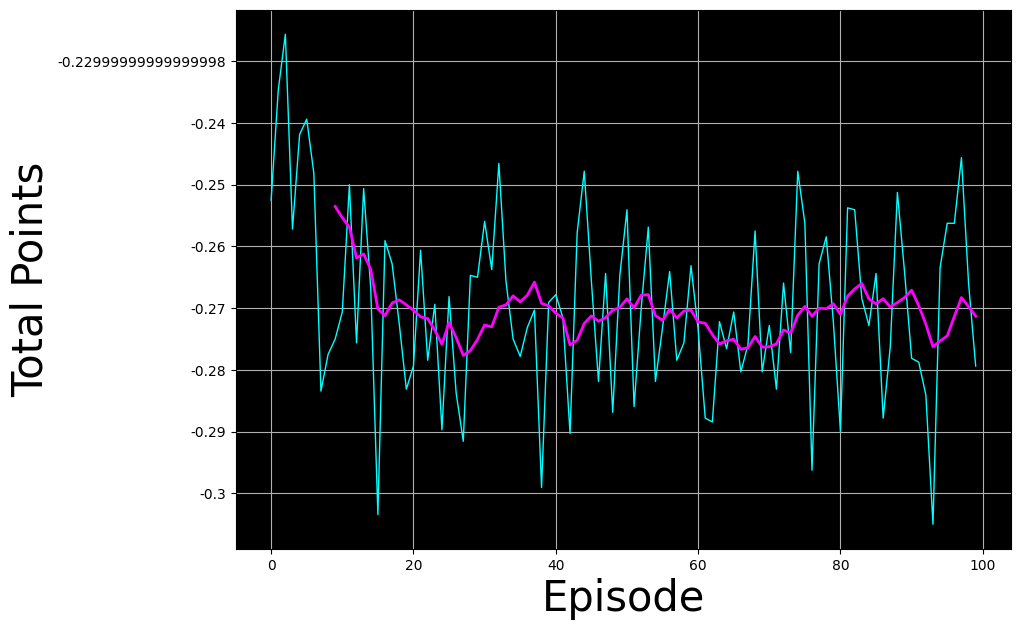

In [13]:
utils.plot_history(test_reward)